In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from gensim import corpora, models, similarities, matutils
import gensim
import dexplot as dxp
from collections import Counter
from matplotlib import rcParams
from gensim import corpora, models, similarities
from itertools import chain
from sklearn.cluster import MeanShift

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None) 

In [3]:
cd desktop

C:\Users\VIJESH\desktop


In [4]:
data=pd.read_csv("processed_reviews_practo.csv") #importing the processed reviews

In [5]:
data=data.dropna(how='any') #dropping all missing reviews

In [6]:
len(data)

14651

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14651 entries, 0 to 14664
Data columns (total 7 columns):
reviews                 14651 non-null object
recommendation          14651 non-null object
location                14651 non-null object
text_clean              14651 non-null object
sentiment               14651 non-null object
reviews_stop_words      14651 non-null object
reviews_stop_words_1    14651 non-null object
dtypes: object(7)
memory usage: 915.7+ KB


In [8]:
data.columns=['reviews', 'recommendation', 'location', 'text_clean', 'sentiment(Recommendation)',
       'reviews_stop_words', 'reviews_stop_words_1']

## Distribution of recommendations

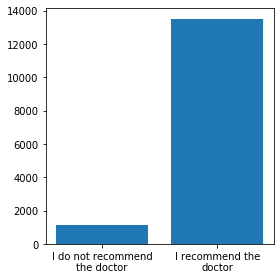

In [9]:
dxp.aggplot(agg="recommendation",data=data,figsize=(4, 4)) 

## Distribution of reviews on location

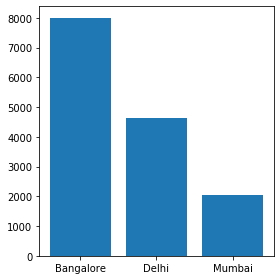

In [10]:
dxp.aggplot(agg="location", data=data,figsize=(4, 4))

## Function to extract sentiment from the reviews

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
def sentiment_scores(sentence): 
  
    sid_obj = SentimentIntensityAnalyzer() 
  
    sentiment_dict = sid_obj.polarity_scores(str(sentence)) #finding polarity score
 
    if sentiment_dict['compound'] >= 0.05 :     #score is greater than 0.05 then the tweet is positive
        return "Positive"
  
    elif sentiment_dict['compound'] <= - 0.05 : #score  less than -0.05 is negative
        return "Negative"
  
    else : 
        return "Neutral"

In [12]:
data['sentiment_vader']=data.apply(lambda row:sentiment_scores(row['reviews']),axis=1) #calling function

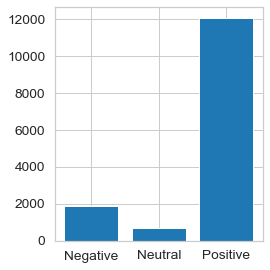

In [115]:
dxp.aggplot(agg="sentiment_vader", data=data,figsize=(4, 4))

## Recommendations vs reviews sentiment

In [13]:
data.groupby('sentiment_vader')['sentiment(Recommendation)']

In [14]:
pd.crosstab(data['sentiment_vader'],data['sentiment(Recommendation)']).apply(lambda x:x*100/len(data),axis=1)

sentiment(Recommendation),Negative,Positive
sentiment_vader,,
Negative,5.160057,7.808341
Neutral,0.709849,4.108935
Positive,2.136373,80.076445


In [15]:
positive_reviews=data.loc[data['sentiment(Recommendation)']=='Positive','reviews_stop_words_1'].tolist()#list of positive reviews
negative_reviews=data.loc[data['sentiment(Recommendation)']=='Negative','reviews_stop_words_1'].tolist()#list of negative reviews

# Recommended Reviews

## Function to get LDA topics

In [16]:
def topics(List):
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer.fit(List)
    counts = count_vectorizer.transform(List).transpose()
    corpus = matutils.Sparse2Corpus(counts)
    id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
    lda = models.LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, passes=1)
    ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=5,passes=10,alpha='auto',per_word_topics=True)
    return lda.print_topics()

## Most common words

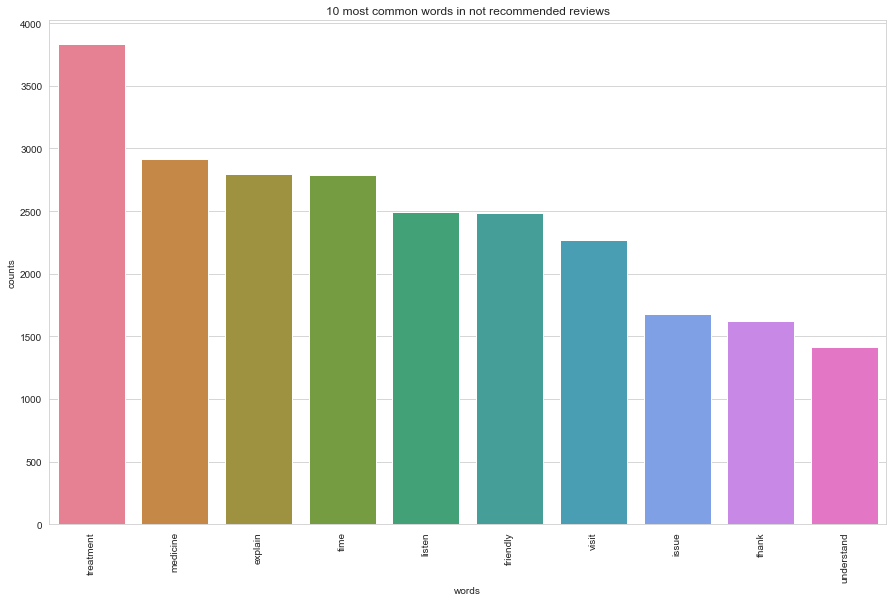

In [17]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    
    sns.set_style('whitegrid')
    %matplotlib inline
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words in not recommended reviews')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(positive_reviews)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [18]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 30
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print(colored("Topics found via LDA:",'green'))
print_topics(lda, count_vectorizer, number_words)

# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=number_topics)
nmf_model.fit(count_data)
print('\n')
print (colored("Topics found via nmf_Z:",'green'))
print_topics(nmf_model, count_vectorizer, number_words)

print('\n')
print (colored("Topics found via lsi_Z:",'green'))
# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=number_topics)
lsi_Z = lsi_model.fit(count_data)
print_topics(lsi_Z, count_vectorizer, number_words)


Topics found via LDA:

Topic #0:
visit clinic listen medicine treatment time issue diagnosis day donot fever test prescribe highly patiently thank suggest treat doc care great consultation family appointment ask consult medication fee professional report

Topic #1:
medicine test prescribe day unnecessary pain treatment donot listen suggest thank medication result visit friendly relief advise laxman therapy help year diagnose suffer advice carefully nap ask feel explain jonwal

Topic #2:
treatment family feel diabetes time visit year make sugar care control thank level treat best life god meet mother come great hospital consult way bless father really say know person

Topic #3:
treatment thank sir consult health fever happy suffer proper life visit come lot satisfy help condition really friend meet start hospital dengue disease month diagnose feel advise father advice year

Topic #4:
explain friendly time treatment listen understand issue nice satisfy medicine health visit really way pa

In [19]:
topics(positive_reviews) #lda for recommended reviews

[(0,
  '0.025*"friendly" + 0.018*"listen" + 0.016*"time" + 0.016*"explain" + 0.014*"prescribe" + 0.013*"donot" + 0.013*"medicine" + 0.011*"treatment" + 0.011*"test" + 0.011*"patiently"'),
 (1,
  '0.017*"treatment" + 0.012*"time" + 0.011*"test" + 0.010*"listen" + 0.010*"medicine" + 0.008*"treat" + 0.008*"visit" + 0.008*"understand" + 0.008*"friendly" + 0.008*"excellent"'),
 (2,
  '0.027*"medicine" + 0.019*"listen" + 0.017*"treatment" + 0.014*"help" + 0.013*"prescribe" + 0.013*"test" + 0.011*"donot" + 0.011*"visit" + 0.011*"lot" + 0.010*"friendly"'),
 (3,
  '0.041*"treatment" + 0.017*"time" + 0.017*"visit" + 0.014*"friendly" + 0.011*"thank" + 0.010*"best" + 0.010*"listen" + 0.010*"explain" + 0.010*"family" + 0.008*"suggest"'),
 (4,
  '0.020*"treatment" + 0.020*"explain" + 0.017*"medicine" + 0.017*"issue" + 0.017*"day" + 0.013*"listen" + 0.013*"visit" + 0.012*"time" + 0.009*"thank" + 0.008*"really"'),
 (5,
  '0.019*"treatment" + 0.018*"medicine" + 0.018*"time" + 0.017*"friendly" + 0.016*"

## K-Means clustering for recommended reviews

In [20]:
tf_idf = TfidfVectorizer(stop_words='english', ngram_range=(1, 4), min_df=25, max_df=0.98)
tf_idf_vecs = tf_idf.fit_transform(positive_reviews)

lsa = TruncatedSVD(100, algorithm='arpack')
lsa_vecs = lsa.fit_transform(tf_idf_vecs)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)
feature_names = tf_idf.get_feature_names()
lsa_df = pd.DataFrame(lsa.components_.round(5), columns=feature_names)

km = KMeans(n_clusters=5, init='k-means++')
km.fit(lsa_vecs)
clusters = km.predict(lsa_vecs)

km.cluster_centers_.shape

original_space_centroids = lsa.inverse_transform(km.cluster_centers_)
original_space_centroids.shape

order_centroids = original_space_centroids.argsort()[:, ::-1]
order_centroids.shape

for cluster in range(5):
    features = order_centroids[cluster,0:5]
    print('Cluster {}\n'.format(cluster))
    for feature in features:
        print(feature_names[feature])
    print('\n')

Cluster 0

explain
friendly
issue
time
friendly explain


Cluster 1

time
friendly
visit
thank
understand


Cluster 2

listen
patiently
carefully
listen patiently
listen carefully


Cluster 3

treatment
satisfy
satisfy treatment
happy
friendly


Cluster 4

medicine
prescribe
test
prescribe medicine
donot




## Not recommended Reviews

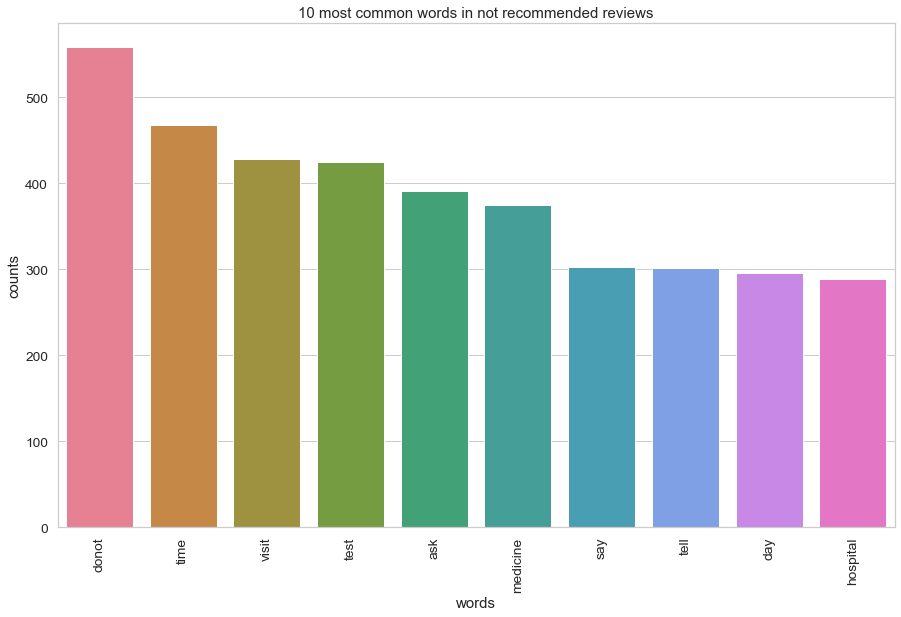

In [21]:
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(negative_reviews)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [22]:
# Tweak the two parameters below
number_topics = 5
number_words = 30
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print(colored("Topics found via LDA:",'green'))
print_topics(lda, count_vectorizer, number_words)

# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=number_topics)
nmf_model.fit(count_data)
print('\n')
print (colored("Topics found via nmf_Z:",'green'))
print_topics(nmf_model, count_vectorizer, number_words)

print('\n')
print (colored("Topics found via lsi_Z:",'green'))
# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=number_topics)
lsi_Z = lsi_model.fit(count_data)
print_topics(lsi_Z, count_vectorizer, number_words)


Topics found via LDA:

Topic #0:
donot test day say medicine ask visit report tell prescribe charge explain check fever consultation bad cough time fee consult suggest write blood hospital pain typhoid pay treatment symptom need

Topic #1:
fever visit consultation ask time test charge rs fee clinic hospital money medicine say practo donot listen case check injection 500 waste mention refer treat dengue come viral day 100

Topic #2:
time wait appointment ask visit donot hour come clinic say hospital book tell reach min 30 practo staff bad consultation medicine available minute day leave 10 make receptionist treatment rude

Topic #3:
donot hospital visit time tell day ask treatment blood medicine test issue fever charge health explain come money admit high report pain suggest check bad say listen consult consultation prescribe

Topic #4:
test medicine prescribe report donot listen ask tell clinic say charge suggest lab expensive treatment write time want visit blood cost medication presc

## K-Means Clustering for not recommended reviews

In [23]:
tf_idf = TfidfVectorizer(stop_words='english', ngram_range=(1, 4), min_df=25, max_df=0.98)
tf_idf_vecs = tf_idf.fit_transform(negative_reviews)

lsa = TruncatedSVD(100, algorithm='arpack')
lsa_vecs = lsa.fit_transform(tf_idf_vecs)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)
feature_names = tf_idf.get_feature_names()
lsa_df = pd.DataFrame(lsa.components_.round(5), columns=feature_names)

km = KMeans(n_clusters=5, init='k-means++')
km.fit(lsa_vecs)
clusters = km.predict(lsa_vecs)

km.cluster_centers_.shape

original_space_centroids = lsa.inverse_transform(km.cluster_centers_)
original_space_centroids.shape

order_centroids = original_space_centroids.argsort()[:, ::-1]
order_centroids.shape

for cluster in range(5):
    features = order_centroids[cluster,0:10]
    print('Cluster {}\n'.format(cluster))
    for feature in features:
        print(feature_names[feature])
    print('\n')

Cluster 0

test
report
blood
fever
blood test
ask
suggest
visit
tell
day


Cluster 1

wait
appointment
time
hour
come
book
clinic
available
reach
donot


Cluster 2

charge
fee
consultation
visit
consultation fee
high
rs
mention
donot
practo


Cluster 3

medicine
prescribe
donot
prescribe medicine
write
explain
clinic
day
tell
bad


Cluster 4

donot
visit
say
time
listen
ask
bad
explain
hospital
treatment




In [24]:
#recommended negative reviews
List_=data.loc[(data['sentiment(Recommendation)']=='Positive')&(data['sentiment_vader']=='Negative'),'reviews_stop_words_1'].tolist()

In [25]:
#not recommended positive reviews
List=data.loc[(data['sentiment(Recommendation)']=='Negative')&(data['sentiment_vader']=='Positive'),'reviews_stop_words_1'].tolist() 

In [26]:
len(List)

313

## Not recommended Positive reviews

In [27]:
tf_idf = TfidfVectorizer(stop_words='english', ngram_range=(1, 4), min_df=25, max_df=0.98)
tf_idf_vecs = tf_idf.fit_transform(List)

lsa = TruncatedSVD()
lsa_vecs = lsa.fit_transform(tf_idf_vecs)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)
feature_names = tf_idf.get_feature_names()
lsa_df = pd.DataFrame(lsa.components_.round(5), columns=feature_names)

km = KMeans(n_clusters=3, init='k-means++')
km.fit(lsa_vecs)
clusters = km.predict(lsa_vecs)

km.cluster_centers_.shape

original_space_centroids = lsa.inverse_transform(km.cluster_centers_)
original_space_centroids.shape

order_centroids = original_space_centroids.argsort()[:, ::-1]
order_centroids.shape





for cluster in range(3):
    features = order_centroids[cluster,0:10]
    print('Cluster {}\n'.format(cluster))
    for feature in features:
        print(feature_names[feature])
    print('\n')

Cluster 0

time
appointment
wait
donot
clinic
come
hour
reach
hospital
say


Cluster 1

test
medicine
visit
donot
day
ask
tell
prescribe
fever
treatment


Cluster 2

donot
time
test
visit
medicine
ask
day
clinic
tell
say




In [28]:
X_dist = km.transform(lsa_vecs)**2

# do something useful...
import pandas as pd
df = pd.DataFrame(X_dist.sum(axis=1).round(2), columns=['sqdist'])
df['label'] = km.labels_


df['reviews']=List
df.head()

,sqdist,label,reviews
0,1.42,0,book practo wait charge extra top seriously donot understand need book practo never app anyone go directly save money
1,2.18,1,many medicine prescribe friendly
2,2.34,0,general hygiene upkeep clinic improve make wait 30 minute confirm time phone fine bite awful staff support clinic avoid
3,2.47,0,unprofessional go serious matter not available clinic close practo confirm availability assure appointment
4,1.83,0,make appointment 115 pm however n't available clinic n't communicate reach tell woman property n't available


## Function to create Bigrams

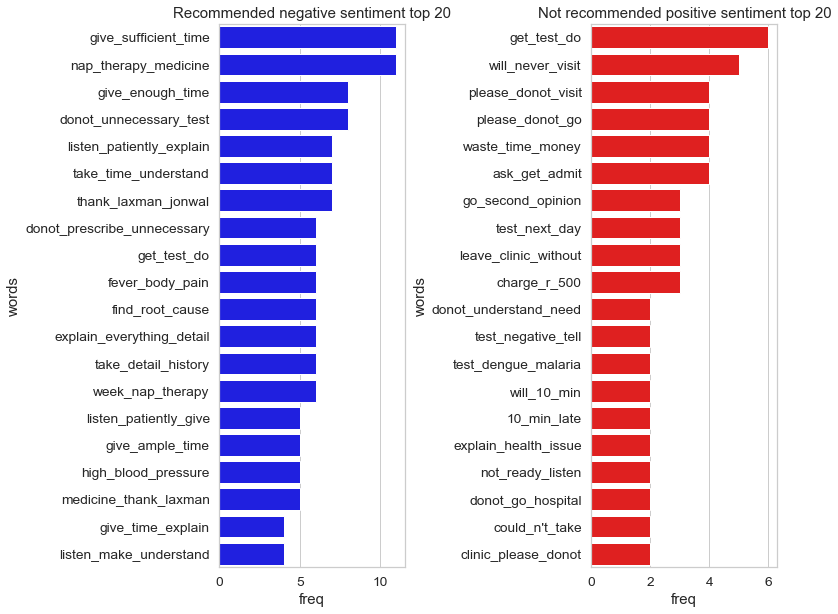

In [29]:
def commonwords(review,top):
    reviews=" ".join(review)
    tokenised_reviews=reviews.split(" ")
    
    
    freq_counter=Counter(tokenised_reviews) #counts the occurance
    return freq_counter.most_common(top)


recommended_negative_sentiment=commonwords(List_,30) #top 30 positive reviews
Not_recommended_positive_sentiment=commonwords(List,30) #top 30 negative reviews

def plotCommonWords(reviews,top,title,color="blue",axis=None):
    top_words=commonwords(reviews,top=top)
    data=pd.DataFrame()
    data['words']=[val[0] for val in top_words]
    data['freq']=[val[1] for val in top_words]
    if axis!=None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title+" top "+str(top))
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title+" top "+str(top))

def generateNGram(text,n=3):  #bigram
    tokens=text.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ["_".join(ngram) for ngram in ngrams] #joins two consecutive words

positive_tweets_bigrams=[" ".join(generateNGram(review)) for review in List_] 
negative_tweets_bigrams=[" ".join(generateNGram(review)) for review in List] 


rcParams['figure.figsize'] = 10,10
fig,ax=plt.subplots(1,2)
fig.subplots_adjust(wspace=1) #Adjusts the space between the two plots
plotCommonWords(positive_tweets_bigrams,20,"Recommended negative sentiment",axis=ax[0])

plotCommonWords(negative_tweets_bigrams,20,"Not recommended positive sentiment",color="red",axis=ax[1])

In [30]:
documents=data['reviews_stop_words_1'] #All reviews

# Analysis using all the reviews

## LDA topic Modelling

In [31]:
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in documents]

# remove words that appear only once
all_tokens = sum(texts, [])
tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
texts = [[word for word in text if word not in tokens_once] for text in texts]

# Create Dictionary.
id2word = corpora.Dictionary(texts)
# Creates the Bag of Word corpus.
mm = [id2word.doc2bow(text) for text in texts]

# Trains the LDA models.
lda = models.ldamodel.LdaModel(corpus=mm, id2word=id2word, num_topics=5)

# Prints the topics.
for top in lda.print_topics():
    print(top)
print

# Assigns the topics to the documents in corpus
lda_corpus = lda[mm]

(0, '0.013*"n" + 0.012*"visit" + 0.012*"not" + 0.010*"charge" + 0.010*"day" + 0.010*"hospital" + 0.010*"treatment" + 0.010*"get" + 0.010*"time" + 0.008*"give"')
(1, '0.019*"get" + 0.018*"go" + 0.016*"day" + 0.012*"test" + 0.012*"take" + 0.011*"medicine" + 0.011*"not" + 0.011*"do" + 0.011*"visit" + 0.010*"pain"')
(2, '0.037*"give" + 0.024*"time" + 0.022*"treatment" + 0.021*"listen" + 0.019*"explain" + 0.014*"issue" + 0.014*"medicine" + 0.012*"understand" + 0.012*"detail" + 0.011*"patiently"')
(3, '0.025*"medicine" + 0.020*"time" + 0.015*"visit" + 0.015*"also" + 0.013*"not" + 0.013*"donot" + 0.013*"explain" + 0.012*"give" + 0.012*"well" + 0.012*"prescribe"')
(4, '0.039*"treatment" + 0.020*"friendly" + 0.020*"well" + 0.016*"explain" + 0.014*"thank" + 0.012*"always" + 0.012*"satisfy" + 0.011*"family" + 0.010*"care" + 0.010*"treat"')


In [32]:
all_topics_csr = gensim.matutils.corpus2csc(lda_corpus) 
topic_score = all_topics_csr.T.toarray().tolist() #probabilty scores for each cluster

In [33]:
cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]
cluster_5=[]

#splitting the respective cluster scores

for i in topic_score:
    cluster_1.append(i[0])
    cluster_2.append(i[1])
    cluster_3.append(i[2])
    cluster_4.append(i[3])
    cluster_5.append(i[4])
 

In [34]:
Topics_data = pd.DataFrame()
Topics_data['Text']=documents
Topics_data['cluster_1']=cluster_1
Topics_data['cluster_2']=cluster_2
Topics_data['cluster_3']=cluster_3
Topics_data['cluster_4']=cluster_4
Topics_data['cluster_5']=cluster_5

In [35]:
Topics_data.head() 

,Text,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,point focus ask right question right go tone accommodate impress,0.018430,0.925589,0.018915,0.018591,0.018476
1,explain issue body tell solve rather prescribe medicine,0.022489,0.022987,0.351128,0.580857,0.022539
2,listen patiently explain everything advise medicine get little releif overall thank,0.016923,0.017184,0.931715,0.017096,0.017082
3,wonderfull explain clearly perfectly alright,0.034654,0.034745,0.035038,0.860519,0.035044
4,book practo wait charge extra top seriously donot understand need book practo never app anyone go directly save money,0.662085,0.307242,0.010242,0.010354,0.010077


## K-Means Clustering

In [114]:
tf_idf = TfidfVectorizer(stop_words='english', ngram_range=(1, 5), min_df=25, max_df=0.98)
tf_idf_vecs = tf_idf.fit_transform(documents)

lsa = TruncatedSVD(n_components=500)
lsa_vecs = lsa.fit_transform(tf_idf_vecs)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)
feature_names = tf_idf.get_feature_names()
lsa_df = pd.DataFrame(lsa.components_.round(5), columns=feature_names)

km = KMeans(n_clusters=5)
km.fit(lsa_vecs)
clusters = km.predict(lsa_vecs)

km.cluster_centers_.shape

original_space_centroids = lsa.inverse_transform(km.cluster_centers_)
original_space_centroids.shape

order_centroids = original_space_centroids.argsort()[:, ::-1]
order_centroids.shape

clusters=[]
topics=[]



for cluster in range(5):
    features = order_centroids[cluster,0:10]
    print('Cluster {}\n'.format(cluster))
    for feature in features:
        print(feature_names[feature])
        topics.append(feature_names[feature])
    clusters.append(topics)
    topics=[]
    print('\n')

Cluster 0

medicine
test
prescribe
donot
prescribe medicine
unnecessary
day
visit
suggest
ask


Cluster 1

explain
friendly
issue
time
friendly explain
treatment
explain issue
clearly
cause
health


Cluster 2

listen
patiently
carefully
listen carefully
listen patiently
medicine
friendly
time
patience
suggest


Cluster 3

time
friendly
visit
understand
thank
clinic
treat
nice
issue
care


Cluster 4

treatment
satisfy
satisfy treatment
happy
thank
friendly
visit
time
result
happy treatment




## determining the cluster distance

In [37]:
sq_distance=km.transform(lsa_vecs)**2
# do something useful...
import pandas as pd
df = pd.DataFrame(sq_distance.sum(axis=1).round(2), columns=['sqdist'])
df['cluster'] = km.labels_


df['reviews']=data['reviews_stop_words_1']
df['recom']=data['sentiment(Recommendation)']
df['sentiment_vader']=data['sentiment_vader']
df=df.join(pd.DataFrame({'cluster 0': sq_distance[:, 0], 'cluster 1': sq_distance[:, 1],'cluster 2': sq_distance[:, 2],'cluster 3': sq_distance[:, 3],'cluster 4': sq_distance[:, 4]}))


In [38]:
df.head()

,sqdist,cluster,reviews,recom,sentiment_vader,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4
0,5.21,0,point focus ask right question right go tone accommodate impress,Positive,Positive,0.998787,1.067678,1.054829,1.052639,1.032337
1,4.93,4,explain issue body tell solve rather prescribe medicine,Positive,Positive,0.974342,1.021261,1.020406,1.030412,0.879643
2,4.85,1,listen patiently explain everything advise medicine get little releif overall thank,Positive,Positive,0.979495,0.851460,1.027747,1.022353,0.968057
3,5.21,0,wonderfull explain clearly perfectly alright,Positive,Positive,0.993854,1.064096,1.052984,1.047494,1.049153
4,5.08,2,book practo wait charge extra top seriously donot understand need book practo never app anyone go directly save money,Negative,Positive,0.994511,1.069628,0.952919,1.050145,1.016151


## Tagging the cluster Name

In [101]:
def cluster(row):
    cluster_no=row['cluster']
    if cluster_no==0:
        return 'nature of treatment'
    if cluster_no==1:
        return 'doctor-interaction'
    if cluster_no==2:
        return 'pre-booking'
    if cluster_no==3:
        return 'post-treatment'
    if cluster_no==4:
        return 'medicine'

In [102]:
df['topics']=df.apply(lambda row:cluster(row),axis=1)

In [103]:
df.head()

,sqdist,cluster,reviews,recom,sentiment_vader,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,topics
0,5.21,0,point focus ask right question right go tone accommodate impress,Positive,Positive,0.998787,1.067678,1.054829,1.052639,1.032337,nature of treatment
1,4.93,4,explain issue body tell solve rather prescribe medicine,Positive,Positive,0.974342,1.021261,1.020406,1.030412,0.879643,medicine
2,4.85,1,listen patiently explain everything advise medicine get little releif overall thank,Positive,Positive,0.979495,0.851460,1.027747,1.022353,0.968057,doctor-interaction
3,5.21,0,wonderfull explain clearly perfectly alright,Positive,Positive,0.993854,1.064096,1.052984,1.047494,1.049153,nature of treatment
4,5.08,2,book practo wait charge extra top seriously donot understand need book practo never app anyone go directly save money,Negative,Positive,0.994511,1.069628,0.952919,1.050145,1.016151,pre-booking


In [104]:
df[df.topics=='pre-booking'].head(5)

,sqdist,cluster,reviews,recom,sentiment_vader,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,topics
4,5.08,2,book practo wait charge extra top seriously donot understand need book practo never app anyone go directly save money,Negative,Positive,0.994511,1.069628,0.952919,1.050145,1.016151,pre-booking
5,4.93,2,wait time will understand explain detail overall satisfaction,Positive,Positive,0.985120,1.043368,0.850365,1.026981,1.028338,pre-booking
10,4.98,2,uma explain issue well 'm still medication wait full course get overall,Positive,Positive,0.963742,1.020549,0.957897,1.022534,1.014373,pre-booking
25,4.84,2,friendly explain issue wait time hire receptionist help,Positive,Positive,0.951231,1.022816,0.846471,1.009089,1.010513,pre-booking
43,4.91,2,spend time explain health issue cause medicine detail explain cause eliminate diet well,Positive,Positive,0.961045,1.017931,0.936104,1.019010,0.977301,pre-booking


In [106]:
df[df.topics=='doctor-interaction'].head(5)

,sqdist,cluster,reviews,recom,sentiment_vader,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,topics
2,4.85,1,listen patiently explain everything advise medicine get little releif overall thank,Positive,Positive,0.979495,0.851460,1.027747,1.022353,0.968057,doctor-interaction
13,4.82,1,second consultation uma helpful first time listen patiently explain thing clearly not take lot time blast difficult medical term 5 5 highly around e city area,Positive,Positive,0.971508,0.905393,0.913699,1.022300,1.008866,doctor-interaction
17,4.85,1,listen carefully examine detail give clear explanation also advise medicine suggest,Positive,Positive,0.990377,0.843170,1.039108,1.029744,0.949785,doctor-interaction
22,5.01,1,descent actually listen give detail explanation cause disease thank,Positive,Positive,0.975667,0.940159,1.037860,1.021203,1.030283,doctor-interaction
23,4.89,1,nice listen carefully tell cause viral fever got best treatment thank mam,Positive,Positive,0.979473,0.899856,1.035006,0.961777,1.009584,doctor-interaction


In [66]:
df[df.topics=='nature of treatment'].head(5)

,sqdist,cluster,reviews,recom,sentiment_vader,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,topics
0,5.21,0,point focus ask right question right go tone accommodate impress,Positive,Positive,0.998787,1.067678,1.054829,1.052639,1.032337,nature of treatment
3,5.21,0,wonderfull explain clearly perfectly alright,Positive,Positive,0.993854,1.064096,1.052984,1.047494,1.049153,nature of treatment
6,5.11,0,do explaine everything well also must tell receptionist unprofessional present think treat badlyi nothing bad tell donot get teach girl receptionist talk people,Negative,Negative,0.981766,1.067432,1.011218,1.052485,0.999782,nature of treatment
9,4.98,0,uma excellent earth friendly need patience explain issue treatment option clearly half solve positive attitude approach god bless,Positive,Positive,0.947786,1.024944,1.019345,0.962346,1.020828,nature of treatment
11,4.97,0,nice way explain help understand issue also wait period less recomend,Positive,Positive,0.951022,1.031587,0.962197,1.010604,1.018872,nature of treatment


In [67]:
df[df.topics=='post-treatment'].head(5)

,sqdist,cluster,reviews,recom,sentiment_vader,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,topics
15,4.91,3,visit uma chicken pox get well treatment advice overall,Positive,Positive,0.971784,1.024644,1.015631,0.881772,1.017153,post-treatment
26,5.06,3,unique bangalore not support use antibiotic tablet less medtion health moto 'm full go treatment friendly polite,Positive,Positive,0.977815,1.047976,1.044015,0.960495,1.030296,post-treatment
30,4.96,3,uma friendly quickly get root cause explain line treatment quite satisfy visit,Positive,Positive,0.964464,1.025350,1.018297,0.931411,1.021513,post-treatment
38,5.00,3,explain clear treatment brilliant kid happy,Positive,Positive,0.980148,1.042443,1.033641,0.905294,1.038178,post-treatment
39,5.01,3,calm start treatment wait see results overall,Positive,Positive,1.002296,1.048943,0.983919,0.929352,1.042198,post-treatment


In [68]:
df[df.topics=='medicine'].head(5)

,sqdist,cluster,reviews,recom,sentiment_vader,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,topics
1,4.93,4,explain issue body tell solve rather prescribe medicine,Positive,Positive,0.974342,1.021261,1.020406,1.030412,0.879643,medicine
7,4.91,4,visit uma twice occasion friendly clearly explain donot unnecessary medicine test,Positive,Positive,0.973344,1.026927,1.015284,1.021007,0.872974,medicine
8,4.72,4,first time visit adept arrive right diagnosis excellent explain u take pain explain medicine give medicine compare something else expertise great attitude favorite physician small clinic nothing fancy reasonably well organize,Positive,Positive,0.931497,0.994590,0.922094,0.977595,0.895314,medicine
12,4.89,4,friendly understand every prescribe right medicine care,Positive,Positive,0.957040,1.013779,1.014165,1.009386,0.893353,medicine
19,5.06,4,simply fabulous know well type medicine will suit also make understand well disease,Positive,Positive,0.976415,1.048947,1.024751,1.031430,0.975624,medicine


In [108]:
doctor_interaction=df[df['topics']=='doctor-interaction']
medicine=df[df['topics']=='medicine']
nature=df[df['topics']=='nature of treatment']
post_treatment=df[df['topics']=='post-treatment']
pre_booking=df[df['topics']=='pre-booking']

In [96]:
len(doctor_interaction)/14651

0.11275680840898232

In [97]:
len(medicine)/14651

0.16067162651013583

In [98]:
len(nature)/14651

0.43505562760221145

In [99]:
len(post_treatment)/14651

0.16135417377653402

In [100]:
len(pre_booking)/14651

0.13016176370213636

In [95]:
len(df)

14651

In [110]:
doctor_interaction.groupby(['topics','sentiment_vader'])['recom'].value_counts().transform(lambda x: x/len(doctor_interaction)*100).unstack()

recom                               Negative   Positive
topics             sentiment_vader                     
doctor-interaction Negative         4.721550  8.777240 
                   Neutral          0.484262  4.479419 
                   Positive         1.513317  79.963680

In [84]:
medicine.groupby(['topics','sentiment_vader'])['recom'].value_counts().transform(lambda x: x/len(medicine)*100).unstack()

recom                     Negative   Positive
topics   sentiment_vader                     
medicine Negative         5.480034  8.198811 
         Neutral          0.679694  4.333050 
         Positive         2.548853  78.632116

In [85]:
nature.groupby(['topics','sentiment_vader'])['recom'].value_counts().transform(lambda x: x/len(nature)*100).unstack()

recom                                Negative   Positive
topics              sentiment_vader                     
nature of treatment Negative         5.145905  7.734547 
                    Neutral          0.721682  3.969250 
                    Positive         2.039536  80.279259

In [86]:
post_treatment.groupby(['topics','sentiment_vader'])['recom'].value_counts().transform(lambda x: x/len(post_treatment)*100).unstack()

recom                           Negative   Positive
topics         sentiment_vader                     
post-treatment Negative         5.033841  6.683587 
               Neutral          0.719120  3.807107 
               Positive         2.199662  81.472081

In [89]:
pre_booking.groupby(['topics','sentiment_vader'])['recom'].value_counts().transform(lambda x: x/len(pre_booking)*100).unstack()

recom                        Negative   Positive
topics      sentiment_vader                     
pre-booking Negative         5.296277  8.127950 
            Neutral          0.891453  4.352386 
            Positive         2.412166  78.867331

In [111]:
df.groupby(['topics','sentiment_vader'])['recom'].value_counts().transform(lambda x: x/len(df)*100).unstack()

recom                                Negative   Positive
topics              sentiment_vader                     
doctor-interaction  Negative         0.532387  0.989694 
                    Neutral          0.054604  0.505085 
                    Positive         0.170637  9.016449 
medicine            Negative         0.880486  1.317316 
                    Neutral          0.109208  0.696198 
                    Positive         0.409528  12.633950
nature of treatment Negative         2.238755  3.364958 
                    Neutral          0.313972  1.726845 
                    Positive         0.887311  34.925944
post-treatment      Negative         0.812231  1.078425 
                    Neutral          0.116033  0.614293 
                    Positive         0.354925  13.145860
pre-booking         Negative         0.689373  1.057948 
                    Neutral          0.116033  0.566514 
                    Positive         0.313972  10.265511

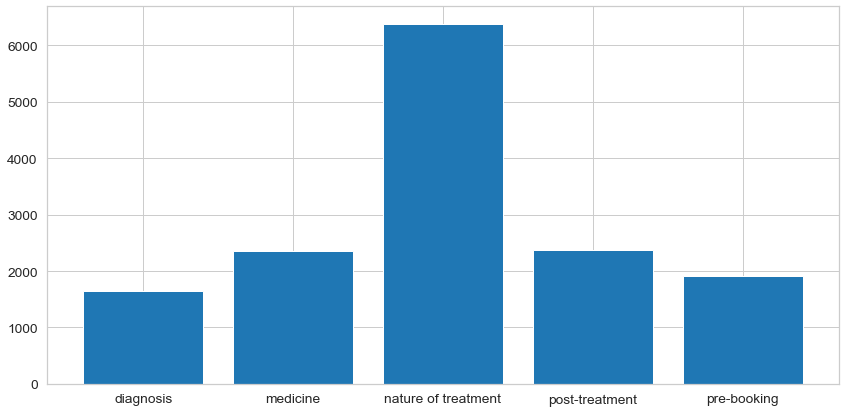

In [70]:
dxp.aggplot(agg="topics", data=df)

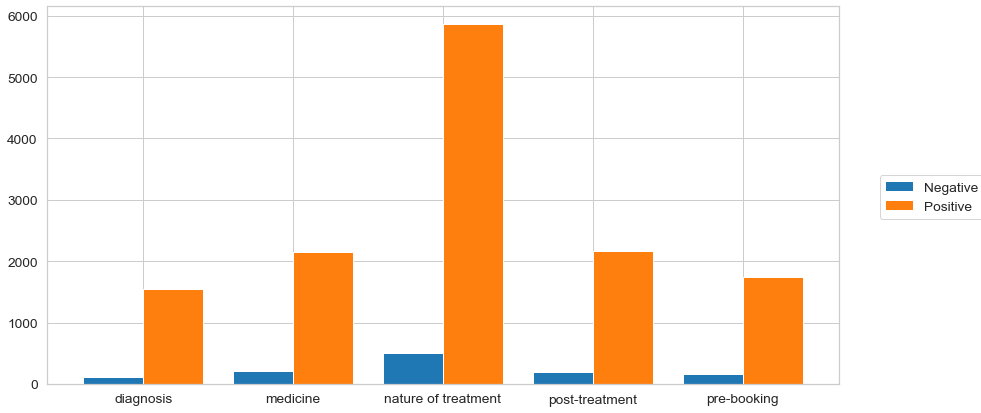

In [71]:
dxp.aggplot(agg="topics", data=df,hue='recom')

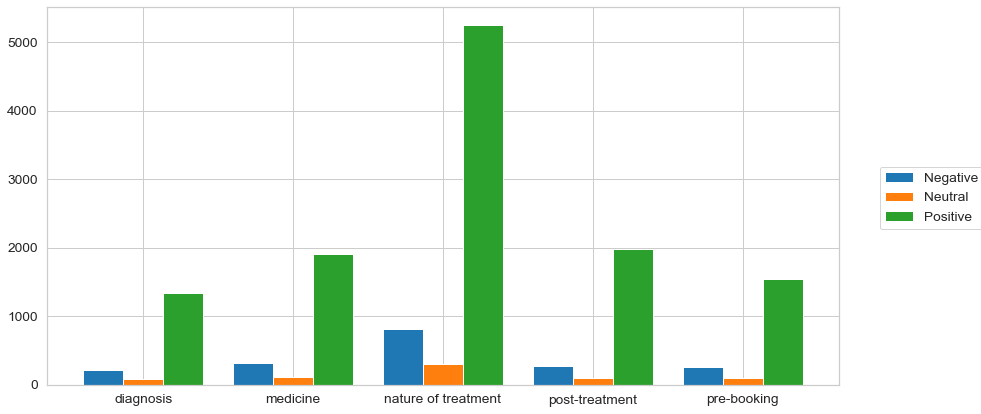

In [72]:
dxp.aggplot(agg="topics", data=df,hue='sentiment_vader')

In [73]:
positive_not_recommended_reviews=df[(df['sentiment_vader']=='Positive')&(df['recom']=='Negative')]

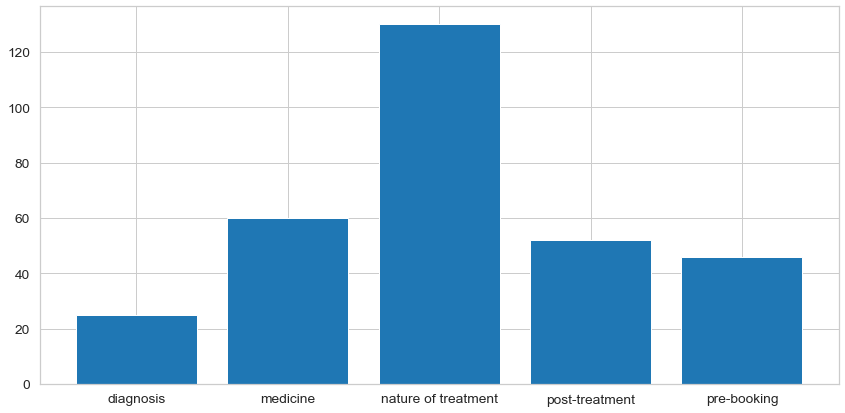

In [74]:
dxp.aggplot(agg="topics", data=positive_not_recommended_reviews)

In [75]:
Negative_recommended_reviews=df[(df['sentiment_vader']=='Negative')&(df['recom']=='Positive')]

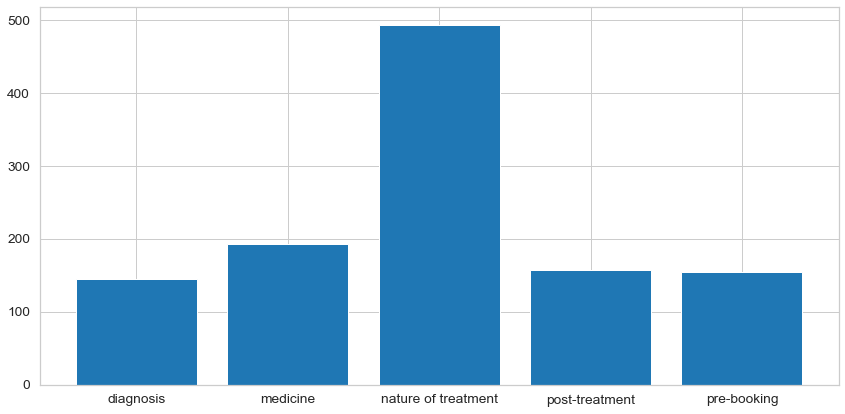

In [76]:
dxp.aggplot(agg="topics", data=Negative_recommended_reviews)

In [55]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 30
count_data = count_vectorizer.fit_transform(data['reviews_stop_words_1'])
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print(colored("Topics found via LDA:",'green'))
print_topics(lda, count_vectorizer, number_words)

# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=number_topics)
nmf_model.fit(count_data)
print('\n')
print (colored("Topics found via nmf_Z:",'green'))
print_topics(nmf_model, count_vectorizer, number_words)

print('\n')
print (colored("Topics found via lsi_Z:",'green'))
# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=number_topics)
lsi_Z = lsi_model.fit(count_data)
print_topics(lsi_Z, count_vectorizer, number_words)


Topics found via LDA:

Topic #0:
treatment thank treat great clinic medicine satisfy family best god friendly help feel visit speak happy monga bless really day life way recover care consult soft result person hospital follow

Topic #1:
pain day visit thank tell suffer say medicine result laxman year treatment hospital therapy relief nap stomach infection jonwal week fever donot chest severe mother feel ask body check issue

Topic #2:
time friendly visit issue explain clinic treatment wait appointment make understand health family staff donot feel highly ask great listen way come question consult professional excellent diagnosis comfortable know answer

Topic #3:
listen explain treatment medicine friendly time issue patiently nice understand satisfy carefully visit health consultation prescribe thing happy suggest care fee charge really patience donot overall test clearly hear medication

Topic #4:
medicine test prescribe donot visit treatment medication unnecessary fever suggest day l

In [56]:
#from sklearn.cluster import AgglomerativeClustering

In [57]:
#import numpy as np

#clustering = AgglomerativeClustering().fit(lsa_vecs)


In [58]:
#from sklearn.metrics.pairwise import cosine_similarity
#dist = 1 - cosine_similarity(lsa_vecs)

In [59]:
#from scipy.cluster.hierarchy import ward, dendrogram

#linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

#fig, ax = plt.subplots(figsize=(100, 100)) # set size
#ax = dendrogram(linkage_matrix, orientation="right");

#plt.show()